# Case Study: Neuro

## Import Packages

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt

# import from absolute directory
srcdir = '/Users/pengzhizhang/cellDancer/src'
srcdir = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/src'
# srcdir = '/Users/wanglab/Documents/ShengyuLi/Velocity/bin/celldancer_polish/src'
#srcdir = '/Users/chen.weiqing/Documents/GitHub/cellDancer/src'
sys.path.append(srcdir)
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
from celldancer.velocity_estimation import velocity
from celldancer.compute_cell_velocity import compute
from celldancer.pseudo_time import pseudo_time
from celldancer.embedding_kinetic_para import embedding

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Velocity Estimation for Sample Genes

In [11]:
%autoreload 2

cell_type_u_s_path="/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/result_detailcsv/test_speed/epoch200check_n10Ratio0.1autoDTrueautoNFalsep3binTruejob40/cell_dancer_velocity_2022-05-26 19-21-01/celldancer_estimation.csv"
#cell_type_u_s_path='/Users/wanglab/Documents/ShengyuLi/Velocity/data/raw_data/DentateGyrus.csv'
#cell_type_u_s_path='/Users/chen.weiqing/code/celldancer/DentateGyrus.csv'
cell_type_u_s=pd.read_csv(cell_type_u_s_path)
cell_type_u_s

,cellIndex,gene_name,splice,unsplice,splice_predict,unsplice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2
0,0,Stom,0.006305,0.000000,0.005999,0.000520,0.001040,0.427941,0.096933,0.070205,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429
1,1,Stom,0.006305,0.000000,0.005999,0.000520,0.001040,0.427941,0.096933,0.070205,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895
2,2,Stom,0.008353,0.000000,0.007948,0.000517,0.001034,0.427932,0.096955,0.070205,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419
3,3,Stom,0.000000,0.000000,0.000000,0.000528,0.001056,0.427962,0.096864,0.070205,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485
4,4,Stom,0.000000,0.000000,0.000000,0.000528,0.001056,0.427962,0.096864,0.070205,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39164255,18135,Prmt8,0.262922,0.131071,0.267516,0.142995,0.100474,0.584625,0.256505,0.112949,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668
39164256,18136,Prmt8,0.531809,0.198949,0.519074,0.199198,0.114583,0.573442,0.262416,0.112949,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788
39164257,18137,Prmt8,0.212177,0.173362,0.235597,0.179191,0.112267,0.580340,0.253414,0.112949,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364
39164258,18138,Prmt8,0.338159,0.216978,0.357323,0.213939,0.118856,0.575789,0.256112,0.112949,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549


In [16]:
%autoreload 2

max_epoches=200
check_val_every_n_epoch=10
patience=3
permutation_ratio=0.1
speed_up=True
norm_u_s=False
norm_cell_distribution=False
n_jobs=8
save_path=None

gene_list=['Ntrk2','Dctn3','Nav1','Psd3',\
           'Gnao1','Ncald','Klf7','Ank2',\
           'Evl','Cdh13','Ppfia2','Astn1',\
           'Nrxn1','Dcx','Prkcg','Pygb','Scn2a1',\
            'Tbc1d16','Slc1a3','Syt11']
#gene_list=['Dcx','Ntrk2']

# Velocity Estimation
loss_df, cellDancer_df=velocity(cell_type_u_s,\
                                         gene_list=gene_list,\
                                         max_epoches=max_epoches,\
                                         check_val_every_n_epoch=check_val_every_n_epoch,\
                                         patience=patience,\
                                         permutation_ratio=permutation_ratio,\
                                         speed_up=speed_up,\
                                         norm_u_s=norm_u_s,\
                                         norm_cell_distribution=norm_cell_distribution,\
                                         n_jobs=n_jobs,\
                                         save_path=save_path)
cellDancer_df

Using /Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/analysis/CaseStudyNotebook/cell_dancer_velocity_2022-05-27 17-58-31 as the output path.
Arranging genes for parallel job.
20  genes were arranged to  1  portion.


Velocity Estimation: 100%|████████████████████████| 1/1 [01:06<00:00, 66.58s/it]


,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2
0,0,Klf7,0.408467,1.294797,0.444935,1.475828,0.454905,0.935128,0.015373,0.077489,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429
1,1,Klf7,0.379136,1.256870,0.411796,1.424216,0.419835,0.935061,0.015772,0.077489,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895
2,2,Klf7,0.893599,3.395004,0.969404,3.832591,1.033540,0.986942,0.001990,0.077489,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419
3,3,Klf7,0.640505,2.739187,0.669036,3.047821,0.684626,0.979797,0.003759,0.077489,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485
4,4,Klf7,0.662303,2.433943,0.712970,2.749427,0.745024,0.971894,0.005226,0.077489,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362795,18135,Prkcg,0.015161,0.007313,0.036056,0.009957,0.050589,0.580371,0.479979,0.091524,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668
362796,18136,Prkcg,0.594831,0.861493,0.579750,0.844472,0.332264,0.609291,0.460210,0.091524,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788
362797,18137,Prkcg,0.016774,0.015733,0.036861,0.016824,0.049916,0.580769,0.480494,0.091524,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364
362798,18138,Prkcg,0.057718,0.034927,0.072546,0.043316,0.063053,0.578594,0.475752,0.091524,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549


## Sample Genes' Velocity Plot

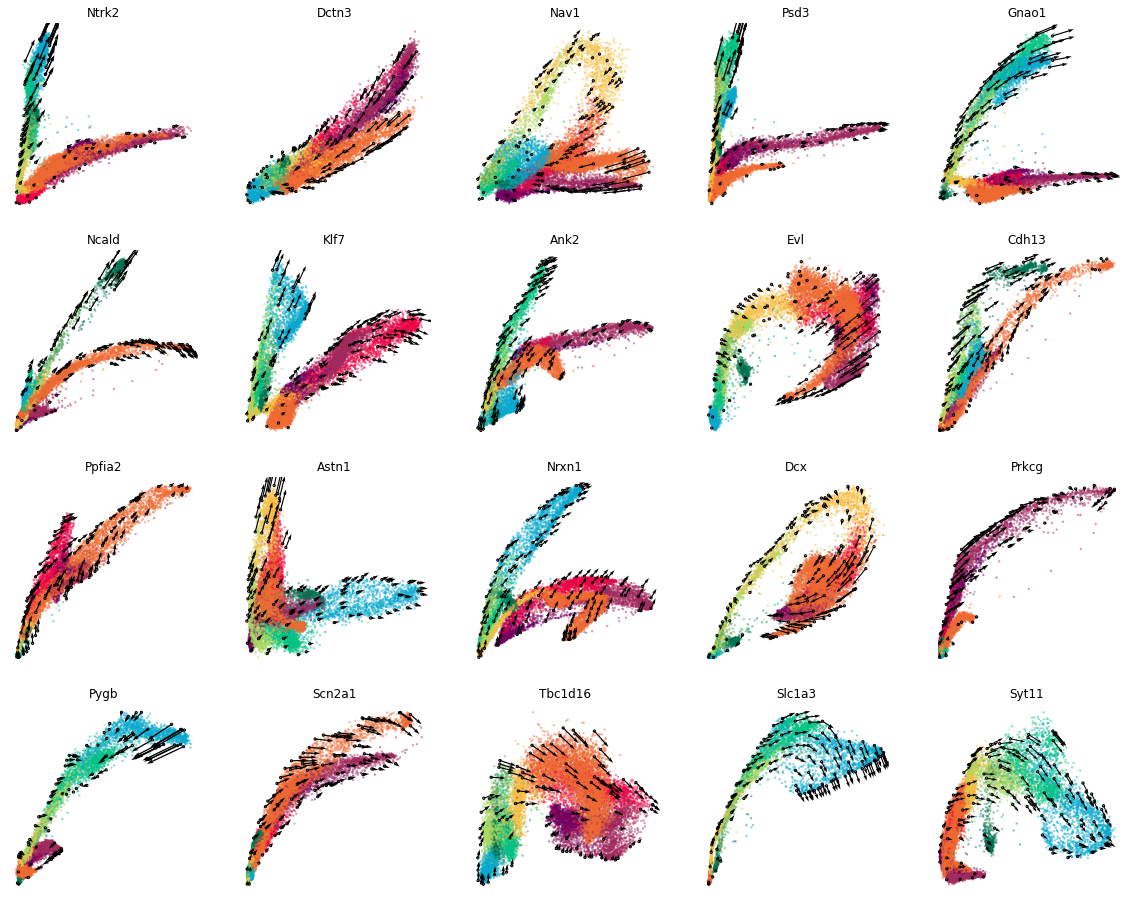

In [17]:
%autoreload 2

gene_list=["Ank","Abcc8","Sulf2","Tcp11","Nfib","Ppp3ca",
        "Rbfox3","Cdk1","Gng12","Map1b","Cpe",
        "Gnao1","Pcsk2","Tmem163","Pak3","Wfdc15b",
        "Nnat","Anxa4","Actn4","Btbd17","Dcdc2a",
        "Adk","Smoc1","Mapre3","Pim2","Tspan7",
        "Top2a","Rap1b"]
gene_list=['Ntrk2','Dctn3','Nav1','Psd3',\
           'Gnao1','Ncald','Klf7','Ank2',\
           'Evl','Cdh13','Ppfia2','Astn1',\
           'Nrxn1','Dcx','Prkcg','Pygb','Scn2a1',\
            'Tbc1d16','Slc1a3','Syt11']
#gene_list=['Dcx','Ntrk2']

ncols=5

height=math.ceil(len(gene_list)/ncols)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_neuro,
        alpha=0.5, 
        s = 5,
        velocity=True,
        gene=gene_list[i])
    
    ax.set_title(gene_list[i])
    ax.axis('off')

plt.show()

## Load velocity estimation result of 2159 genes

In [53]:
#detail_file = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/Gastrulation/velocity_result/result_detailcsv/2000genes_with_bin_and_smooth/combined_detail/combined_detail.csv'
cellDancer_df_file = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/result_detailcsv/test_speed/epoch200check_n10Ratio0.1autoDTrueautoNFalsep3binTruejob40/cell_dancer_velocity_2022-05-26 19-21-01/celldancer_estimation.csv'
cellDancer_df=pd.read_csv(cellDancer_df_file)
cellDancer_df

,cellIndex,gene_name,splice,unsplice,splice_predict,unsplice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2
0,0,Stom,0.006305,0.000000,0.005999,0.000520,0.001040,0.427941,0.096933,0.070205,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429
1,1,Stom,0.006305,0.000000,0.005999,0.000520,0.001040,0.427941,0.096933,0.070205,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895
2,2,Stom,0.008353,0.000000,0.007948,0.000517,0.001034,0.427932,0.096955,0.070205,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419
3,3,Stom,0.000000,0.000000,0.000000,0.000528,0.001056,0.427962,0.096864,0.070205,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485
4,4,Stom,0.000000,0.000000,0.000000,0.000528,0.001056,0.427962,0.096864,0.070205,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39164255,18135,Prmt8,0.262922,0.131071,0.267516,0.142995,0.100474,0.584625,0.256505,0.112949,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668
39164256,18136,Prmt8,0.531809,0.198949,0.519074,0.199198,0.114583,0.573442,0.262416,0.112949,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788
39164257,18137,Prmt8,0.212177,0.173362,0.235597,0.179191,0.112267,0.580340,0.253414,0.112949,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364
39164258,18138,Prmt8,0.338159,0.216978,0.357323,0.213939,0.118856,0.575789,0.256112,0.112949,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549


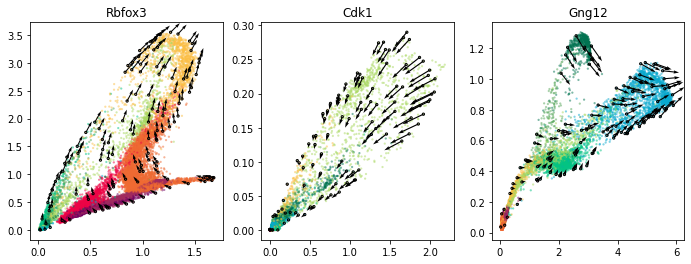

In [70]:
gene_list=["Ank","Abcc8","Sulf2","Tcp11","Nfib","Ppp3ca",
        "Rbfox3","Cdk1","Gng12","Map1b","Cpe",
        "Gnao1","Pcsk2","Tmem163","Pak3","Wfdc15b",
        "Nnat","Anxa4","Actn4","Btbd17","Dcdc2a",
        "Adk","Smoc1","Mapre3","Pim2","Tspan7",
        "Top2a","Rap1b"][6:9]

ncols=5

height=math.ceil(len(gene_list)/5)*4
fig = plt.figure(figsize=(20,height))
# fig = plt.figure(figsize=(20,20))
for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_neuro,
        alpha=0.5, 
        s = 5,
        velocity=True,
        gene=gene_list[i])
    
    ax.set_title(gene_list[i])

plt.show()

## Compute Cell Velocity

(genes, cells): (2157, 18140)


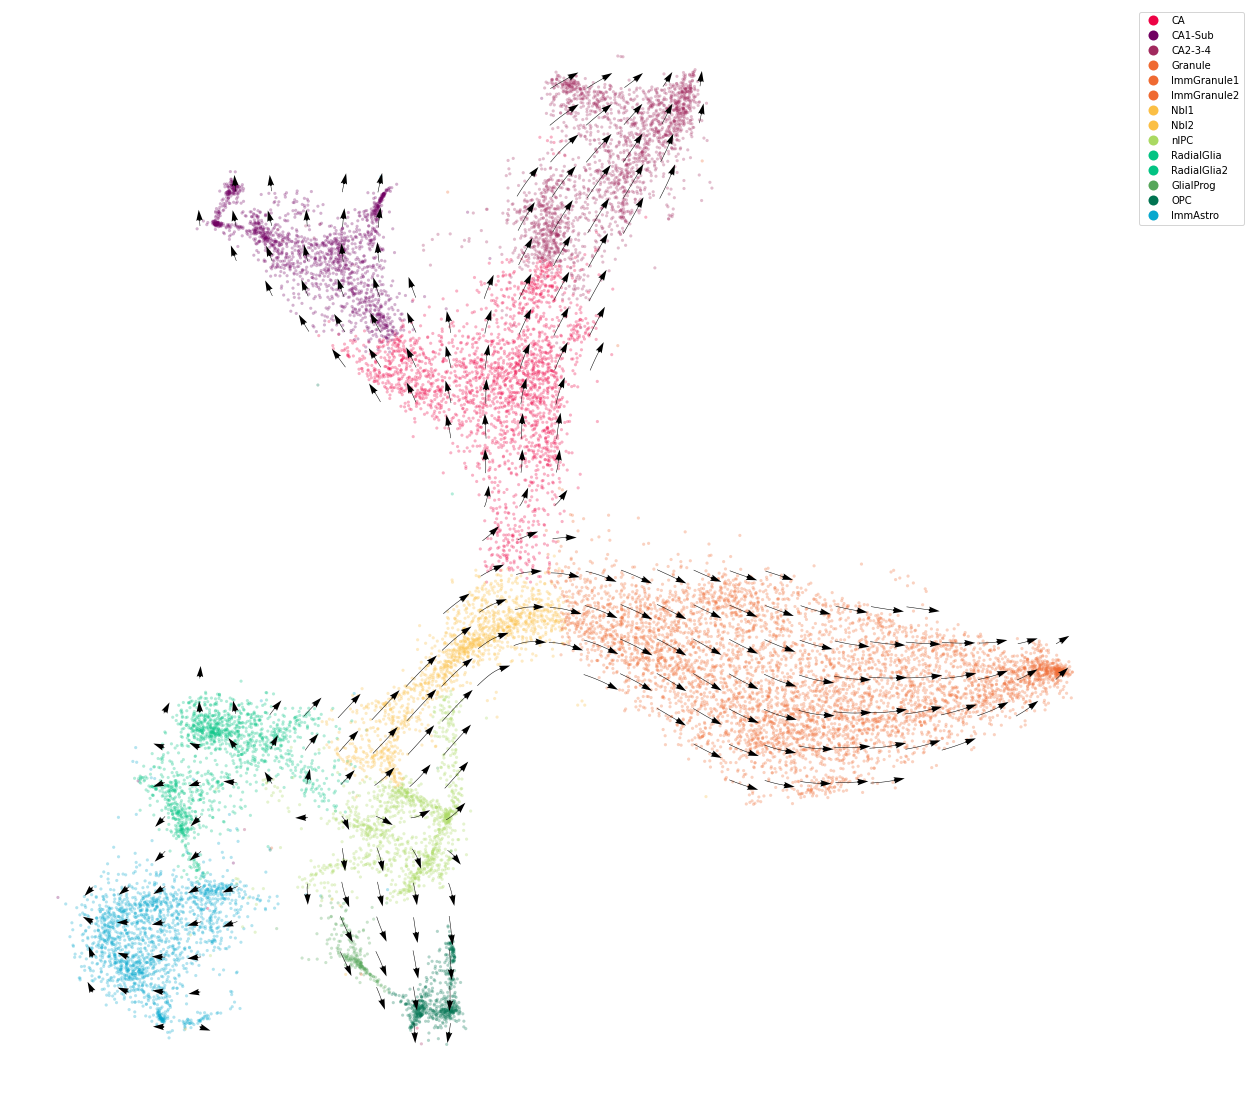

In [59]:
%autoreload 2

# Set Parameters
projection_neighbor_choice='embedding'
expression_scale=None
projection_neighbor_size=200
speed_up=(60,60)

# Compute cell velocity
cellDancer_df=compute(cellDancer_df=cellDancer_df,
              projection_neighbor_choice=projection_neighbor_choice,
              expression_scale=expression_scale,
              projection_neighbor_size=projection_neighbor_size,
              speed_up=speed_up)

# Plot cell velocity
# Set Parameters
min_mass=2
arrow_grid=(30,30)
alpha_inside=0.3


fig, ax = plt.subplots(figsize=(20,20))
im = cdplt.cell.scatter_cell(ax,cellDancer_df, colors=colormap.colormap_neuro, alpha=alpha_inside, s=10,
             velocity=True, legend='on',min_mass=min_mass,arrow_grid=arrow_grid)
ax.axis('off')
plt.show()

## Estimate Pseudotime

Pseudo random numbers seeds are:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


100%|███████████████████████████████████████| 8880/8880 [05:49<00:00, 25.38it/s]


use path_similarity:  0.25
There are 5 clusters.
[0 1 2 3 4]


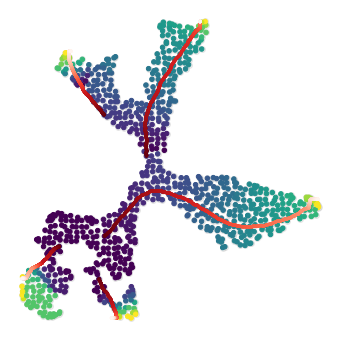




Cluster  0
Total cells in the cluster:  485
MAX allowed zero time cells:  24
MAX allowed terminal cells:  24
Only  1  terminal cells left.
[595]
63  zero cells left.
Sample trajs for zero-time cells in cluster  0   ...
Pseudo random numbers seeds are:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



Cluster  0
Total cells in the cluster:  63
MAX allowed zero time cells:  24
MAX allowed terminal cells:  24
Only  23  zero cells left. 
[22, 64, 80, 90, 99, 131, 145, 204, 248, 258, 266, 280, 394, 403, 414, 416, 425, 481, 564, 569, 572, 682, 781]
Only  1  terminal cells left.
[593]
number of paths:  2 2

Display reference paths for cluster 0


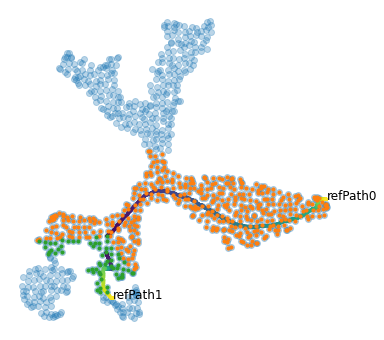


intercluster cell time adjustment
number of cells:  485
Cutoff is  0.05436230636414892
Number of nodes:  2
clusterIDs:  [0, 1]

Consolidating time between clusters  0  and  1 ...
pair_cellIDs:  (734, 572)
pair_cellIDs:  (307, 280)
pair_cellIDs:  (102, 90)
pair_cellIDs:  (306, 488)
pair_cellIDs:  (438, 416)
pair_cellIDs:  (343, 414)
pair_cellIDs:  (807, 781)
pair_cellIDs:  (34, 319)
pair_cellIDs:  (653, 348)
pair_cellIDs:  (23, 394)
pair_cellIDs:  (13, 131)
pair_cellIDs:  (203, 569)
pair_cellIDs:  (451, 22)
pair_cellIDs:  (148, 266)
pair_cellIDs:  (845, 201)
pair_cellIDs:  (260, 564)
pair_cellIDs:  (576, 598)
pair_cellIDs:  (161, 157)
pair_cellIDs:  (579, 3)
pair_cellIDs:  (705, 99)
pair_cellIDs:  (261, 425)
pair_cellIDs:  (505, 138)
pair_cellIDs:  (24, 122)
pair_cellIDs:  (856, 145)
pair_cellIDs:  (2, 204)
pair_cellIDs:  (802, 403)
pair_cellIDs:  (318, 172)

Peak mode:  most_frequent_shift


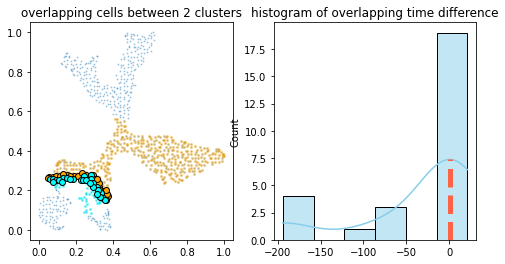

Time shift is:  1
The overlapping cells are: 
cell  734  from cluster  0  and  572  from cluster  1


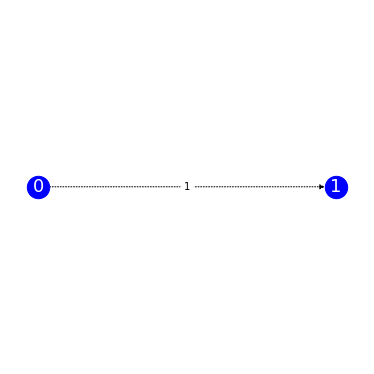

Connected components:  {0, 1}
All nodes adjustment:  {0: 0, 1: 1}



Cluster  1
Total cells in the cluster:  248
MAX allowed zero time cells:  12
MAX allowed terminal cells:  12
Only  0  zero cells left. 
[]
Only  1  terminal cells left.
[641]
number of paths:  1 1

Display reference paths for cluster 1


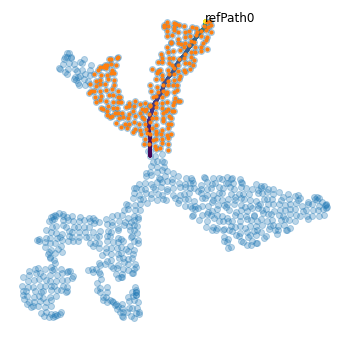




Cluster  2
Total cells in the cluster:  35
MAX allowed zero time cells:  10
MAX allowed terminal cells:  10
Only  0  zero cells left. 
[]
Only  2  terminal cells left.
[230, 649]
number of paths:  1 1

Display reference paths for cluster 2


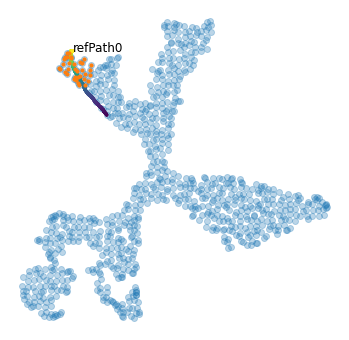




Cluster  3
Total cells in the cluster:  82
MAX allowed zero time cells:  10
MAX allowed terminal cells:  10
Only  0  zero cells left. 
[]
Only  2  terminal cells left.
[448, 742]
number of paths:  1 1

Display reference paths for cluster 3


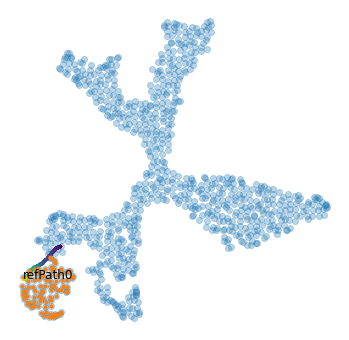




Cluster  4
Total cells in the cluster:  38
MAX allowed zero time cells:  10
MAX allowed terminal cells:  10
Only  0  zero cells left. 
[]
Only  4  terminal cells left.
[631, 651, 664, 732]
number of paths:  1 1

Display reference paths for cluster 4


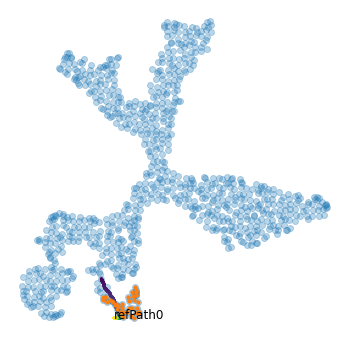




All intra cluster cell time has been resolved.




intercluster cell time adjustment
number of cells:  888
Cutoff is  0.05800183740382286
Number of nodes:  5
clusterIDs:  [0, 1, 2, 3, 4]

Consolidating time between clusters  0  and  1 ...
pair_cellIDs:  (195, 32)
pair_cellIDs:  (776, 299)
pair_cellIDs:  (357, 855)
pair_cellIDs:  (43, 56)
pair_cellIDs:  (640, 103)
pair_cellIDs:  (238, 735)

Peak mode:  most_frequent_shift


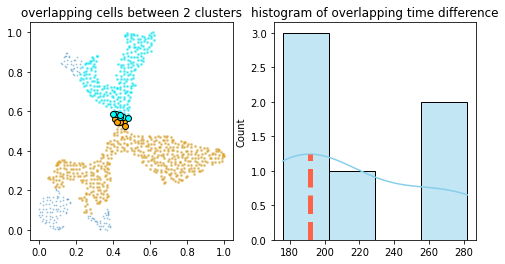

Time shift is:  195
The overlapping cells are: 
cell  43  from cluster  0  and  56  from cluster  1

Consolidating time between clusters  0  and  2 ...
No close cells between clusters	 (0, 2)

Consolidating time between clusters  0  and  3 ...
pair_cellIDs:  (315, 48)
pair_cellIDs:  (325, 538)
pair_cellIDs:  (426, 54)
pair_cellIDs:  (481, 75)
pair_cellIDs:  (557, 345)
pair_cellIDs:  (248, 667)

Peak mode:  most_frequent_shift


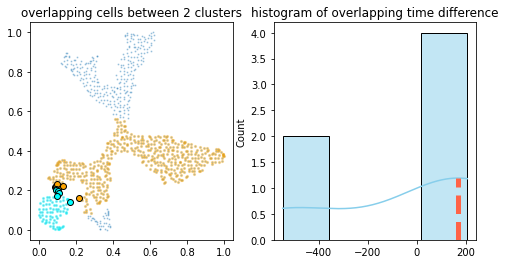

Time shift is:  160
The overlapping cells are: 
cell  315  from cluster  0  and  48  from cluster  3

Consolidating time between clusters  0  and  4 ...
pair_cellIDs:  (593, 830)
pair_cellIDs:  (887, 687)
pair_cellIDs:  (581, 748)
pair_cellIDs:  (344, 310)
pair_cellIDs:  (157, 199)
pair_cellIDs:  (833, 870)

Peak mode:  most_frequent_shift


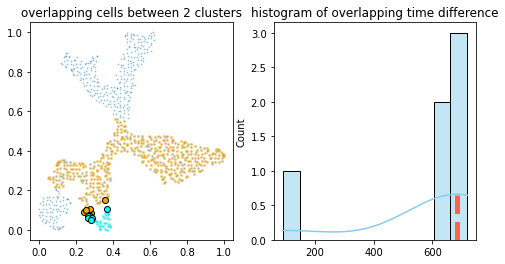

Time shift is:  688
The overlapping cells are: 
cell  581  from cluster  0  and  748  from cluster  4

Consolidating time between clusters  1  and  2 ...
pair_cellIDs:  (184, 281)
pair_cellIDs:  (296, 252)
pair_cellIDs:  (160, 285)
pair_cellIDs:  (196, 20)
pair_cellIDs:  (381, 38)
pair_cellIDs:  (366, 182)
pair_cellIDs:  (427, 216)
pair_cellIDs:  (127, 173)

Peak mode:  most_frequent_shift


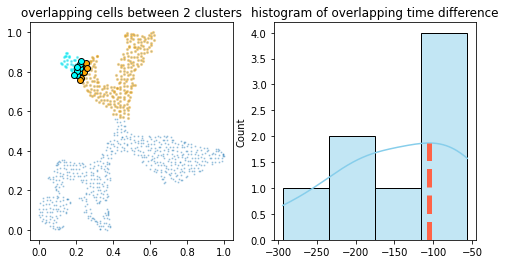

Time shift is:  0
The overlapping cells are: 
cell  296  from cluster  1  and  252  from cluster  2

Consolidating time between clusters  1  and  3 ...
No close cells between clusters	 (1, 3)

Consolidating time between clusters  1  and  4 ...
No close cells between clusters	 (1, 4)

Consolidating time between clusters  2  and  3 ...
No close cells between clusters	 (2, 3)

Consolidating time between clusters  2  and  4 ...
No close cells between clusters	 (2, 4)

Consolidating time between clusters  3  and  4 ...
No close cells between clusters	 (3, 4)


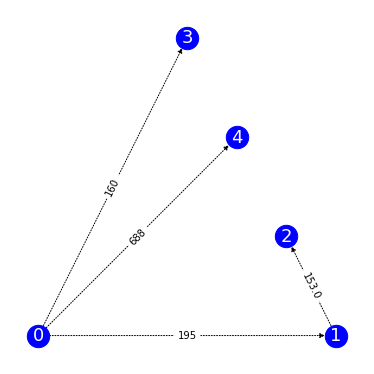

Connected components:  {0, 1, 2, 3, 4}
All nodes adjustment:  {0: 0, 1: 195, 2: 195, 3: 160, 4: 688}


All inter cluster cell time has been resolved.



There are 18140 cells.


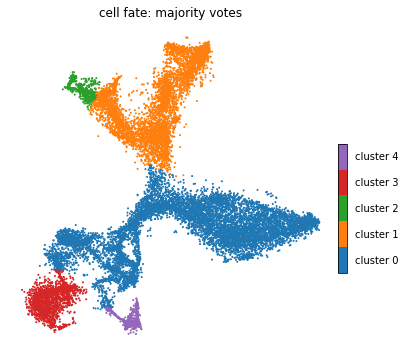

--- 578.0994009971619 seconds ---


In [60]:
%autoreload 2

dt = 0.001
t_total = {0.001: 10000}
n_repeats = 10

downsample_step=(60,60)
grid = (30, 30)
load_cellDancer = pseudo_time(
    load_cellDancer=cellDancer_df, 
    grid=grid, 
    dt=dt, 
    t_total=t_total[dt], 
    n_repeats=n_repeats, 
    downsample_step=downsample_step,
    n_paths = 5,
    psrng_seeds_diffusion=[i for i in range(n_repeats)],
    activate_umap_paths_divider=False,
    n_jobs=12)

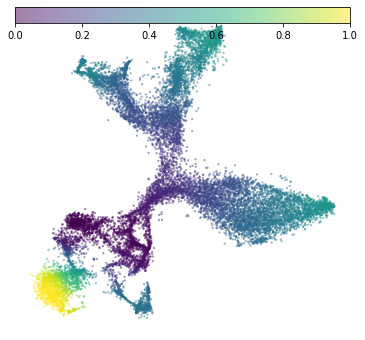

In [61]:
## Plot Pseudotime
fig, ax = plt.subplots(figsize=(6,6))
im=cdplt.cell.scatter_cell(ax,cellDancer_df, colors='pseudotime', alpha=0.5, 
             velocity=False)
ax.axis('off')
plt.show()

## Gene Pseudotime

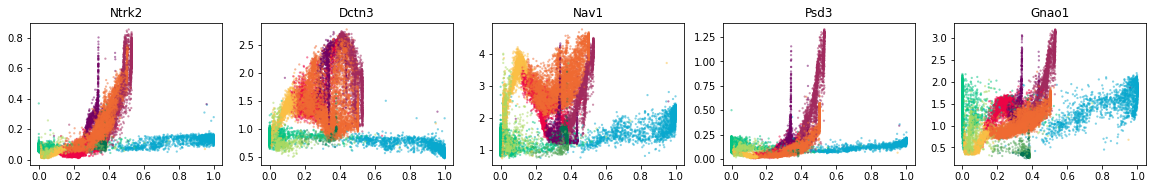

In [63]:

ncols=5
fig = plt.figure(figsize=(20,12))
for i in range(len(gene_list[0:5])):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='pseudotime',
        y='splice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_neuro,
        alpha=0.5, 
        s = 5,
        velocity=False,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    # ax.axis('off')

## Gene Parameter in Cell Level

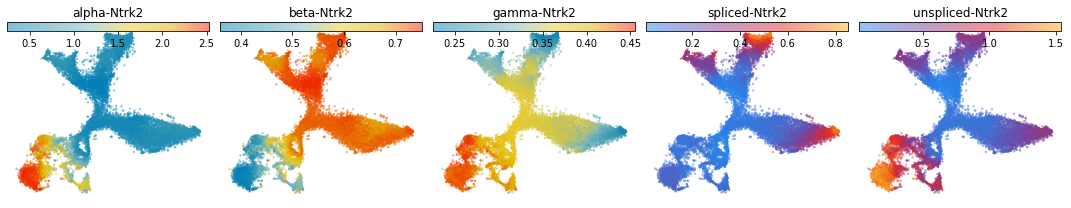

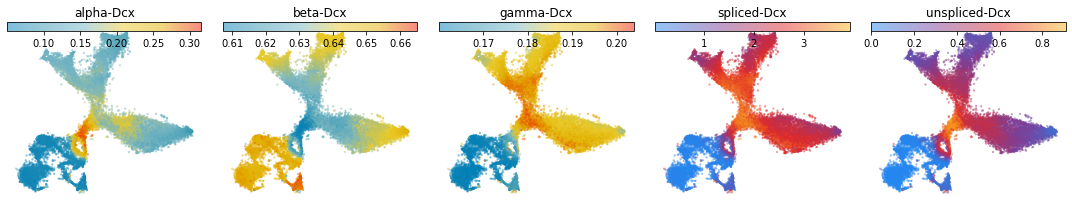

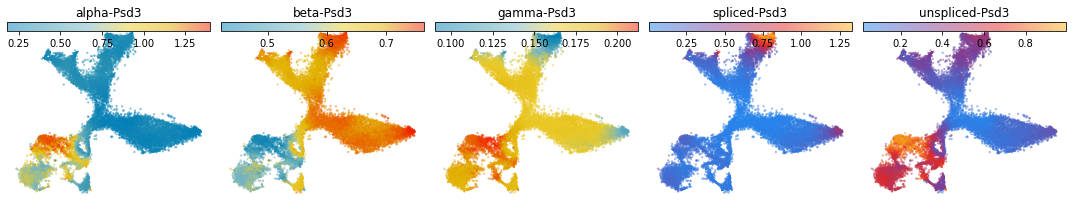

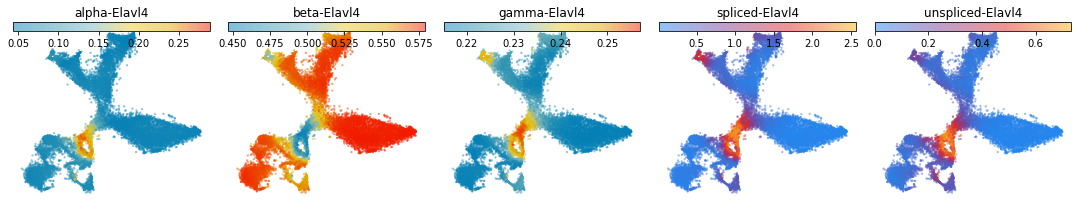

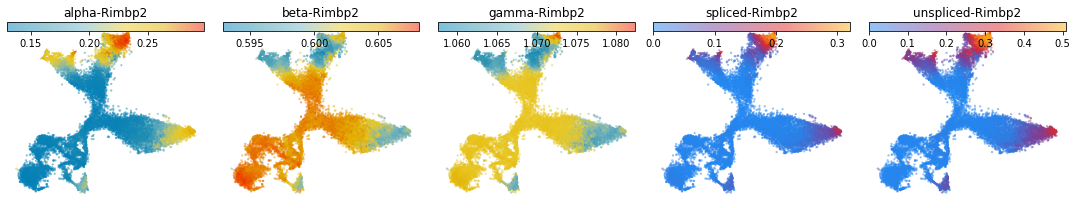

In [64]:
gene_samples=['Ntrk2','Dcx','Psd3','Elavl4','Rimbp2']
for gene in gene_samples:
    fig, ax = plt.subplots(ncols=5, figsize=(15,3))
    cdplt.cell.scatter_cell(ax[0],cellDancer_df, colors='alpha', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[1],cellDancer_df, colors='beta', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[2],cellDancer_df, colors='gamma', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[3],cellDancer_df, colors='splice', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[4],cellDancer_df, colors='unsplice', 
                 gene=gene, velocity=False)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    ax[4].axis('off')
    ax[0].set_title('alpha-'+gene)
    ax[1].set_title('beta-'+gene)
    ax[2].set_title('gamma-'+gene)
    ax[3].set_title('spliced-'+gene)
    ax[4].set_title('unspliced-'+gene)
    plt.tight_layout()
    plt.show()

## UMAP using alpha, beta, and gamma

In [31]:
cellDancer_df=embedding(cellDancer_df,'alpha')
cellDancer_df=embedding(cellDancer_df,'beta')
cellDancer_df=embedding(cellDancer_df,'gamma')
cellDancer_df=embedding(cellDancer_df,'alpha_beta_gamma')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


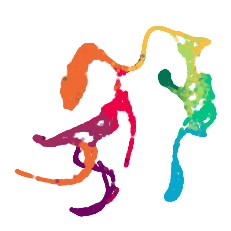

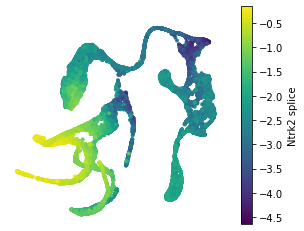

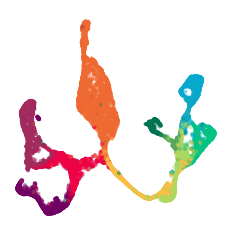

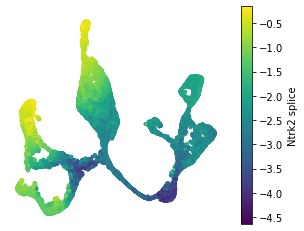

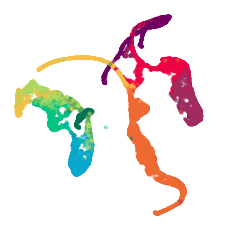

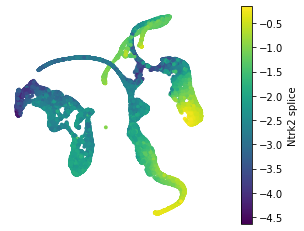

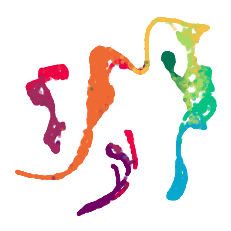

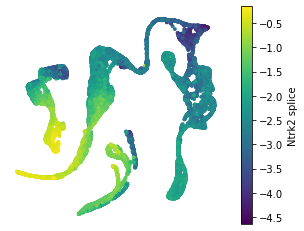

In [35]:
cdplt.cell.plot_kinetic_para('alpha',cellDancer_df,color_map=cdplt.colormap.colormap_neuro, save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('beta',cellDancer_df,color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('beta',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('gamma',cellDancer_df,color_map=cdplt.colormap.colormap_neuro,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('gamma',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha_beta_gamma',cellDancer_df,color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha_beta_gamma',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)